# **Fair Minimum Representation Clustering with Column Generation**

In [1]:
import numpy as np
#import cvxpy as cp
#%pip install repliclust
#%pip install -i https://pypi.gurobi.com gurobipy;
import gurobipy as gp

In [2]:
from gurobipy import GRB
from repliclust import set_seed, Archetype, DataGenerator
import matplotlib.pyplot as plt

**Master problem**

\begin{align*}
&\textbf{min} & \sum_{k}r_kz_k & \\
&\textbf{s.t.} & \sum_{k \in C} s_{i,k}z_k &= 1, \forall i\\
&  \quad & \sum_{k \in C} t_{g,k}z_k &\geq \beta_g, \forall g \\
&  \quad & \sum_{k \in C} z_k &= K \\
&  \quad & z_k &\in \{0,1\}
\end{align*}

$k$: the $k$-th cluster of points

$g$: the group of points with label $g$

$C$: the set of all clusters

$r_k$ : sum of squared 2-norm of distances between points in cluster $k$ and the center of cluster $k$.

$z_k$ : decision variables that determine if a cluster is selected.

$\beta_g$: least number of $\alpha$ represented cluster for group $g$.

$s_{i,k}$: parameters that determine if point $i$ is in cluster $k$.

$t_{g,k}$: parameters that determine if cluster $k$ is $\alpha$-represented for group $g$.

**Pricing problem**

\begin{align}
&\textbf{min} &\space (\sum_{\forall i} r_i - \sum_{\forall i} \mu_is_i &- \sum_{\forall g} \lambda_gt_g)\\
&\textbf{s.t.} &\sum_{\forall i} q_{g,i}s_i + M(1-t_g) &\geq \alpha_g\sum_{\forall i} s_i, \forall g\\
& & r_i + M(1-s_i) &\geq ||x_i - c||_2^2, \forall i\\
& & u \geq \sum_{\forall i} s_i &\geq l, \forall i\\
& & r_i \geq 0, s_i, t_g \in \{0,1\}, c &\in \mathbb{R}^n
\end{align}

$s_i$ : decision variables determining if point $i$ is in the generated cluster.

$t_g$ : decision variables determining if the generated cluster is $\alpha$-represented for group $g$.

$r_i$ : decision variables for the contribution of squared 2-norm of point $i$ to the sum of distances between points and the center of cluster in the new cluster.

$c$ : decision variable for the center of the new cluster.

$\mu_i$ : dual variables for constraints \ref{eq:master-cons-1}.

$\lambda_g$ : dual variables for constraints \ref{eq:master-cons-2}.

$q_{g,i}$ : parameters that determine if point $i$ is in group $g$.

$u$ : upper bound for the number of points in a cluster

$l$ : lower bound for the number of points in a cluster

In [ ]:
def master_warm_start(model):
  

In [3]:
def solve_master_problem_gurobi(n, m, l, r, s, t, beta, K):
    # Create a Gurobi model
    model = gp.Model("MasterProblem")
    #model.Params.LogToConsole = 0

    # Create decision variables
    Z = model.addMVar(m, vtype=GRB.CONTINUOUS, name="Z")

    # Set objective function
    model.setObjective(gp.quicksum(Z[i] * r[i] for i in range(m)), GRB.MINIMIZE)

    # Constraints
    constraint1 = []
    constraint2 = []

    for i in range(n):
      constraint1.append(model.addConstr(gp.quicksum(s[k][i] * Z[k] for k in range(m)) == 1, name="Constraint1_"+str(i)))

    for g in range(l):
      constraint2.append(model.addConstr(gp.quicksum(t[g][k] * Z[k] for k in range(m)) >= beta[g], name="Constraint2_"+str(g)))

    constraint_3 = [model.addConstr(gp.quicksum(Z[k] for k in range(m)) == K, name="Constraint3")]

    for k in range(m):
        model.addConstr(Z[k] <= 1, name="Constraint4_"+str(k))
        model.addConstr(Z[k] >= 0, name="Constraint5_"+str(k))

    # Solve the problem
    model.optimize()

    # Print objective value
    print('Objective:', model.objVal)

    # Print variable values
    for i, var in enumerate(model.getVars()):
        print(f"{var.varName} = {var.x}")

    # Print dual variables
    print("Dual values:")
    for constr in model.getConstrs():
        print(f"{constr.ConstrName}: {constr.Pi}")

    constraints = list(model.getConstrs())

    mu = [cons_i.Pi for cons_i in constraints[:n]]

    lmd = [cons_g.Pi for cons_g in constraints[n:n+l]]

    delta = constraints[n+l].Pi

    # for cons_i in constraints[:n]:
    #   mu.append(cons_i.Pi)

    # lmd = []
    # for cons_g in constraints[n:n+l]:
    #   lmd.append(cons_g.Pi)

    optimal_values_Z = [int(Z[k].x) for k in range(m)]

    return mu, lmd, model.objVal, optimal_values_Z, delta

In [4]:
def solve_pricing_problem_gurobi(n, l, r, q, alpha, beta, delta, K, M, x, y, mu, lmd, lower, upper):
    # Create a Gurobi model
    model = gp.Model("PricingProblem")
    #model.Params.LogToConsole = 0

    # Create decision variables
    r = model.addMVar(n, vtype=GRB.CONTINUOUS, name="R")
    s = model.addMVar(n, vtype=GRB.BINARY, name="S")
    t = model.addMVar(l, vtype=GRB.BINARY, name="t")
    cx = model.addVar(vtype=GRB.CONTINUOUS, lb = -100, name="cx")
    cy = model.addVar(vtype=GRB.CONTINUOUS, lb = -100, name="cy")

    # Objective function

    objective = gp.quicksum(r[i] for i in range(n)) \
                - gp.quicksum(mu[i] * s[i] for i in range(n)) \
                - gp.quicksum(lmd[g] * t[g] for g in range(l)) \
                - delta
    model.setObjective(objective , GRB.MINIMIZE)

    # Constraints
    constraints = []

    for g in range(l):
      constraints.append(model.addConstr(gp.quicksum(q[g][i] * s[i] for i in range(n)) + M*(1-t[g]) >= alpha * gp.quicksum(s[i] for i in range(n)), name="Constraint1"))

    for i in range(n):
      constraints.append(model.addConstr(r[i] + M*(1-s[i]) >= (x[i] - cx)**2 + (y[i] - cy)**2, name="Constraint2"))
      constraints.append(model.addConstr(r[i] >= 0, name="Constraint3"))

    constraints.append(model.addConstr(gp.quicksum(s[i] for i in range(n)) >= lower, name="Constraint3"))
    constraints.append(model.addConstr(gp.quicksum(s[i] for i in range(n)) <= upper, name="Constraint4"))

    # Solve the problem
    model.optimize()

    # Print objective value
    print('Objective:', model.objVal)

    # Print variable values
    for var in model.getVars():
      print(f"{var.varName} = {var.x}")

    # Print constraints
    # for constr in constraints:
    #   print(constr)

    optimal_values_s = [int(np.round(s[i].x)) for i in range(n)]
    optimal_values_r = [float(r[i].x) for i in range(n)]
    optimal_values_t = [int(np.round(t[g].x)) for g in range(l)]

    return model.objVal, optimal_values_s, optimal_values_r, optimal_values_t

In [5]:
def main_loop(iterations,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y):
  reduced_cost = 1
  counter = 1
  while counter < iterations:
    print("Iteration #"+str(counter))
    print("s:",s)
    print("r:",r)
    print("t:",t)
    counter += 1
    mu, lmd, masterobj, optimal_values_Z, delta = solve_master_problem_gurobi(n, m, l, r, s, t, beta, K)
    #
    reduced_cost, optimal_values_s, optimal_values_r, optimal_values_t = solve_pricing_problem_gurobi(n, l, r, q, alpha, beta, delta, K, M, x, y, mu, lmd, lower, upper)
    print("New cluster found")
    print(optimal_values_s)
    if reduced_cost >= -1e-4:
      print("Termination")
      print("Number of iterations", counter)
      print("Objective:",masterobj)
      print("Z:")
      print(optimal_values_Z)
      print("s:")
      print(s)
      print("Clusters:")
      for i in range(len(s)):
        if optimal_values_Z[i] > 0:
          print(s[i])
      break
    if optimal_values_s in s:
      raise Exception("Error: Repetition")
    s.append(optimal_values_s)
    r.append(sum(optimal_values_r))
    for g in range(l):
      t[g].append(optimal_values_t[g])
    m += 1
  
  

In [6]:
K = 2
n = 5
m = 6
l = 2
r = [0.5, 8/3, 1, 0.5, 1, 1]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1],
              [0, 0, 1, 0, 1],
              [0, 0, 1, 1, 0]]
t =          [[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 1, 1]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(8,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y)

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0]]
r: [0.5, 2.6666666666666665, 1, 0.5, 1, 1]
t: [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1]]
Set parameter Username
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 6 columns and 35 nonzeros
Model fingerprint: 0x267b656a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 20 rows and 6 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03

In [9]:
K = 2
n = 5
m = 5
l = 2
r = [0.5, 8/3, 1, 0.5, 1]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1],
              [0, 0, 1, 1, 0]]
t =          [[1, 0, 0, 0, 0],
              [0, 1, 0, 0, 1]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(20,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y)

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 1, 1, 0]]
r: [0.5, 2.6666666666666665, 1, 0.5, 1]
t: [[1, 0, 0, 0, 0], [0, 1, 0, 0, 1]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 18 rows, 5 columns and 29 nonzeros
Model fingerprint: 0x93e42048
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 18 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.166666667e+00
Objective: 3.1666666666666665
Z[0] = 1.0
Z[1] = 1.0
Z[2] = 0.0
Z[3] = 0.0
Z[4] = 0.0
Dual values:
Constraint1_0: -1.6666666666666665
Constraint1_1: -2.1666666666666665
Constraint1_2: 0.0
Constraint1_3: 0.0
Constraint1_4: 2.6666666666666665
Constraint2_0: 4.333333333333333
Constraint2_1: 0.0
Constraint3: 0.0
Constraint4_0: 0.0
Constraint5_0: 0.0
Constrai

In [10]:
K = 2
n = 5
m = 4
l = 2
r = [0.5, 8/3, 1, 0.5]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1]]
t =          [[1, 0, 0, 0],
              [0, 1, 0, 0]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(20,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y)

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1]]
r: [0.5, 2.6666666666666665, 1, 0.5]
t: [[1, 0, 0, 0], [0, 1, 0, 0]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16 rows, 4 columns and 23 nonzeros
Model fingerprint: 0x4a5417d0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 16 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.166666667e+00


Objective: 3.1666666666666665
Z[0] = 1.0
Z[1] = 1.0
Z[2] = 0.0
Z[3] = 0.0
Dual values:
Constraint1_0: 0.0
Constraint1_1: 0.0
Constraint1_2: 2.6666666666666665
Constraint1_3: 0.0
Constraint1_4: 0.0
Constraint2_0: 0.5
Constraint2_1: 0.0
Constraint3: 0.0
Constraint4_0: 0.0
Constraint5_0: 0.0
Constraint4_1: 0.0
Constraint5_1: 0.0
Constraint4_2: 0.0
Constraint5_2: 0.0
Constraint4_3: 0.0
Constraint5_3: 0.0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9 rows, 14 columns and 27 nonzeros
Model fingerprint: 0xb668db29
Model has 5 quadratic constraints
Variable types: 7 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [2e+00, 1e+03]
  QRHS ra

In [12]:
K = 2
n = 5
m = 2
l = 2
r = [0.5, 8/3]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1]]
t =          [[1, 0],
              [0, 1]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(20,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y)

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1]]
r: [0.5, 2.6666666666666665]
t: [[1, 0], [0, 1]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12 rows, 2 columns and 13 nonzeros
Model fingerprint: 0xc5b5ffd3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.166666667e+00


Objective: 3.1666666666666665
Z[0] = 1.0
Z[1] = 1.0
Dual values:
Constraint1_0: 0.5
Constraint1_1: 0.0
Constraint1_2: 2.6666666666666665
Constraint1_3: 0.0
Constraint1_4: 0.0
Constraint2_0: 0.0
Constraint2_1: 0.0
Constraint3: 0.0
Constraint4_0: 0.0
Constraint5_0: 0.0
Constraint4_1: 0.0
Constraint5_1: 0.0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9 rows, 14 columns and 27 nonzeros
Model fingerprint: 0xdd2980ce
Model has 5 quadratic constraints
Variable types: 7 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+03]
  Objective range  [5e-01, 3e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [2e+00, 1e+03]
  QRHS range       [1e+03, 1e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolved: 6 r

Exception: Error: Repetition

In [151]:
#test distance minimization
m = gp.Model()

# Create variables
x = m.addVar(vtype=GRB.CONTINUOUS, lb = -100, name="x")
y = m.addVar(vtype=GRB.CONTINUOUS, lb = -100, name="y")
# r1 = m.addVar(vtype=GRB.CONTINUOUS, name="r1")
# r2 = m.addVar(vtype=GRB.CONTINUOUS, name="r2")
# r3 = m.addVar(vtype=GRB.CONTINUOUS, name="r3")

# Set objective function
m.setObjective((x - 0)**2 + (y-0)**2 + (x - (-1))**2 + (y-0)**2 + (x - 0)**2 + (y-(-1))**2, gp.GRB.MINIMIZE)

# Add constraints
# m.addConstr(r1 >= )
# m.addConstr(r2 >= )
# m.addConstr(r3 >= )

# Solve it!
m.optimize()

print(f"Optimal objective value: {m.objVal}")
print(x.x)
print(y.x)

x0 = -1/3
y0 = -1/3
print((x0 - 0)**2 + (y0-0)**2 + (x0 - (-1))**2 + (y0-0)**2 + (x0 - 0)**2 + (y0-(-1))**2)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 2 columns and 0 nonzeros
Model fingerprint: 0xb5b2b57e
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+00, 2e+00]
  QObjective range [6e+00, 6e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective 1.33333333e+00
Optimal objective value: 1.3333333333333333
-0.3333333333333333
-0.3333333333333333
1.3333333333333335




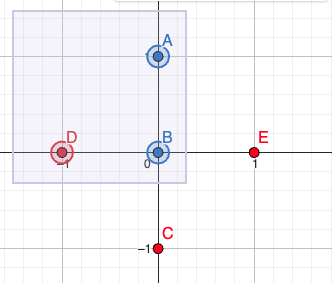

Synthetic data for clustering

In [7]:
n = 100

archetype_oblong = Archetype(n_clusters=5, dim=2, n_samples=n,
                             aspect_ref=3, aspect_maxmin=1.5, max_overlap = 0.002, min_overlap = 0.001, 
                             name="oblong")
data_generator = DataGenerator(archetype=archetype_oblong)

Optimizing Cluster Centers: 100%|██████████| 300/300 [00:00<00:00, 8280.63it/s, Status=SUCCESS]


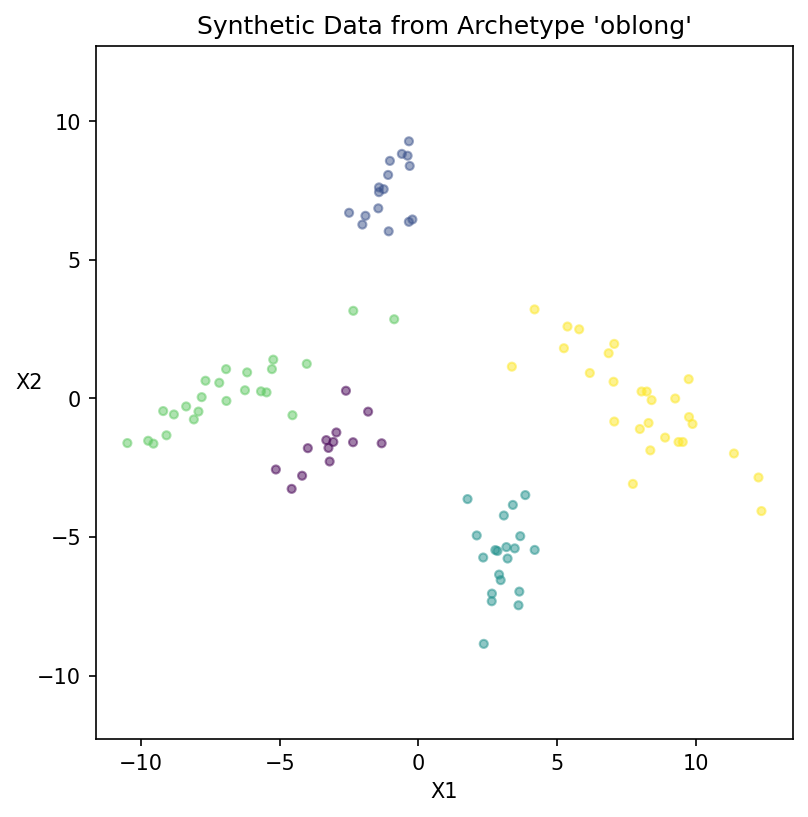

In [8]:
set_seed(3)
X, Y, archetype = data_generator.synthesize()

fig, ax = plt.subplots(figsize=(6,6), dpi=150)
ax.scatter(X[:,0], X[:,1], c=Y, s=15, alpha=0.5, linewidth=1.0)
plt.title("Synthetic Data from Archetype '"
            + archetype.name + "'")
plt.xlabel('X1')
plt.ylabel('X2').set_rotation(0)
plt.axis('equal');

In [111]:
# K = 5
# n = 500
# x0 = [-10, -5, 0, 5, 10]
# y0 = [-10, -5, 0, 5, 10]

# clusters = [[0 for _ in range(K)] for _ in range(n)]
# clusters_assign = [0 for _ in range(n)]

# for i in range(n):
#   x = X[i][0]
#   y = X[i][1]

#   min_dist = float(np.inf)
#   argmin = 0
#   for j in range(K):
#     dist = (x-x0[j])**2 + (y-y0[j])**2
#     if dist < min_dist:
#       min_dist = dist
#       argmin = j
#   clusters[i][argmin] = 1
#   clusters_assign[i] = argmin

Generate initial clusters

In [19]:
K = 5
clusters_assign_random = np.random.choice(list(range(K)), size=n)

xc = [0 for _ in range(K)]
yc = [0 for _ in range(K)]
cluster_size = [0 for _ in range(K)]

for i in range(n):
  k = int(clusters_assign_random[i])
  cluster_size[k] += 1
  xc[k] += X[i][0]
  yc[k] += X[i][1]

for k in range(K):
  xc[k] /= cluster_size[k]
  yc[k] /= cluster_size[k]

dist = [0 for _ in range(K)]

for i in range(n):
  k = int(clusters_assign_random[i])
  dist[k] += (X[i][0] - xc[k]) **2 + (X[i][1] - yc[k]) **2

print(xc,yc)
print(dist)

[0.44395661930174485, -1.4854132116825682, 1.3466498161676337, 2.99324711471998, -0.7362511358983495] [0.04937258722932998, -1.0411009383230698, -0.6439082271206265, 1.0217083913281726, -0.10945080662509553]
[1158.7940373158092, 699.1175466861541, 1470.7319234136771, 667.2639623395165, 993.9585129192208]


(-11.645624740010858,
 13.51858575867008,
 -9.763850766545351,
 10.180626072794452)

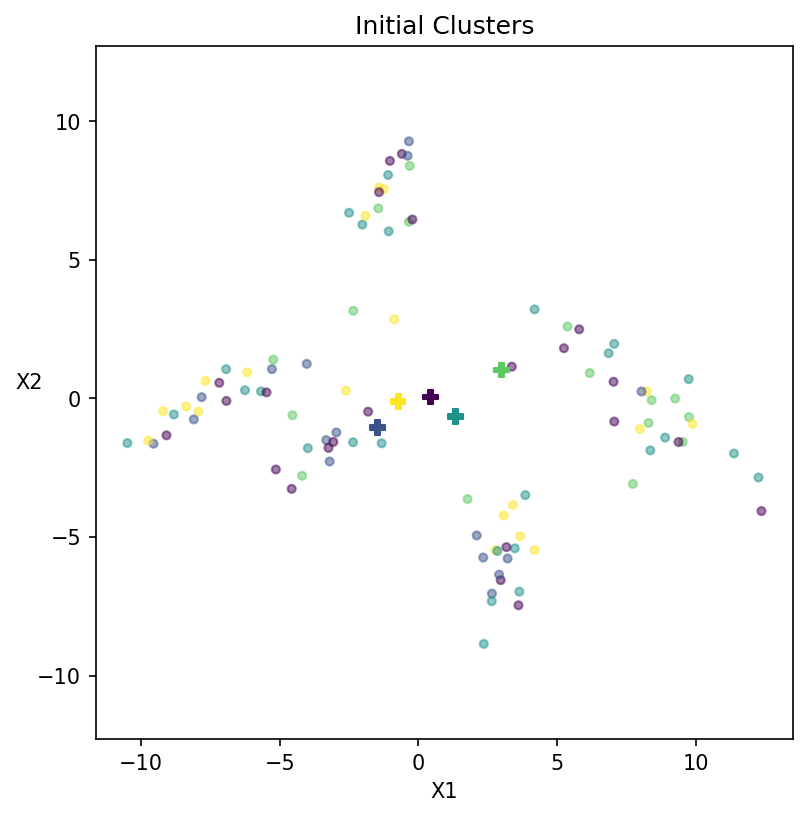

In [20]:
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
ax.scatter(X[:,0], X[:,1], c=clusters_assign_random, s=15, alpha=0.5, linewidth=1.0)
ax.scatter(xc, yc, marker='P', c=list(range(K)), s=50, linewidth=1.0)

plt.title("Initial Clusters")
plt.xlabel('X1')
plt.ylabel('X2').set_rotation(0)
plt.axis('equal')

In [21]:
labels = np.random.choice([0,1,2], p= [0.1,0.2,0.7], size=n)
# dependence between labels and clusters

(-11.645624740010858,
 13.51858575867008,
 -9.763850766545351,
 10.180626072794452)

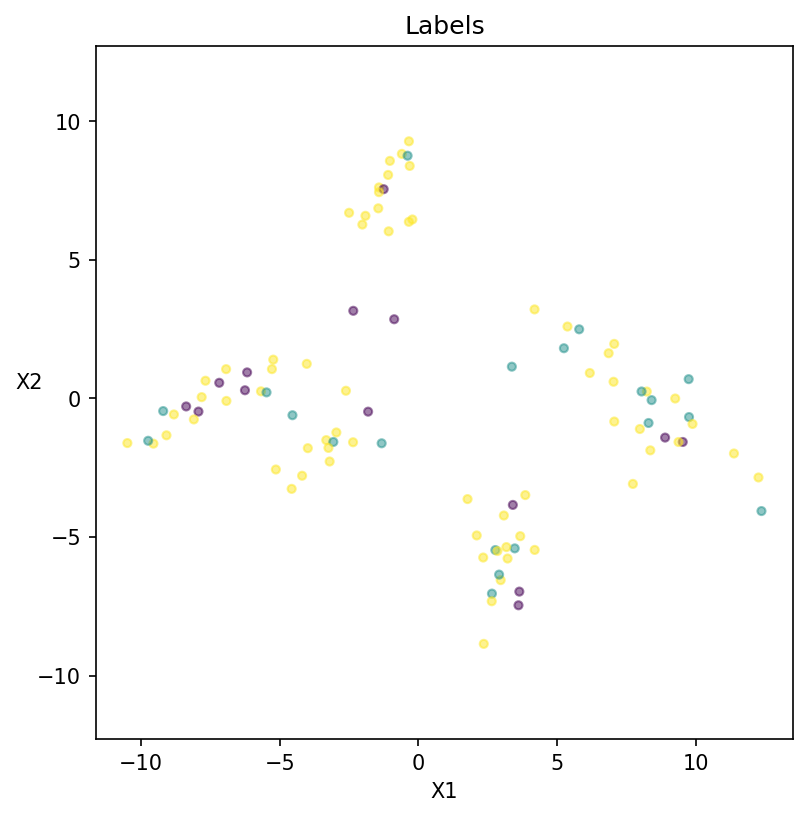

In [22]:
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
ax.scatter(X[:,0], X[:,1], c=labels, s=15, alpha=0.5, linewidth=1.0)

plt.title("Labels")
plt.xlabel('X1')
plt.ylabel('X2').set_rotation(0)
plt.axis('equal')

1 synthetic data
2 big M
3 dependence
4 dimension
5 

In [23]:
clusters_random = [[0 for _ in range(n)] for _ in range(K)]
for i in range(n):
  k = int(clusters_assign_random[i])
  clusters_random[k][i] = 1
print(clusters_random)

[[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [24]:
l = 3
q = [[0 for _ in range(n)] for _ in range(l)]
for i in range(n):
  label = int(labels[i])
  q[label][i] = 1
print(q)

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]]


In [25]:
alpha = 1/2
label_stats = [[0 for _ in range(K)] for _ in range(l)]
t = [[0 for _ in range(K)] for _ in range(l)]
for i in range(n):
  label = int(labels[i])
  k = int(clusters_assign_random[i])
  label_stats[label][k] += 1

print(label_stats)
print(cluster_size)

for i in range(l):
  for k in range(K):
    if label_stats[i][k] >= alpha * cluster_size[k]:
      t[i][k] = 1

print(t)

[[3, 0, 3, 2, 6], [6, 4, 3, 4, 3], [14, 12, 20, 10, 10]]
[23, 16, 26, 16, 19]
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 1, 1, 1, 1]]


In [26]:
K = 5
m = 5
r = dist.copy()
s = clusters_random.copy()
beta = [0,0,1]
M = 1e5
lower = 2
upper = n

main_loop(100,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,X[:,0],X[:,1])

Iteration #1
s: [[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0

## Example
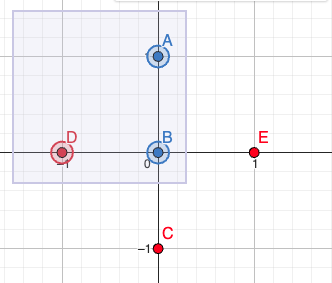

$g = \text{"blue"}, \alpha = \frac{2}{3}, \beta = 1, l = 2$

In [ ]:
def solve_master_problem(n,m,r,k,alpha_rep):
  Z = cp.Variable(m, name = "Z")
  k_t = np.transpose(k)
  ones = np.transpose(np.ones(n))

  new_ones = np.transpose(np.ones(m))

  # Objective
  objective = Z @ r

  # Constraints
  constraints = []
  constraints += [k_t @ Z == ones]
  constraints += [alpha_rep @ Z >= 1]
  constraints += [new_ones @ Z == 2]

  # add constraints...

  for i in range(m):
    constraints += [Z[i] <= 1]
    constraints += [Z[i] >= 0]

  # Define problem
  problem = cp.Problem(cp.Minimize(objective), constraints)

  # Solve problem
  problem.solve(solver='GUROBI')
  print('objective %s' % problem.value)

  # Print variable values
  for variable in problem.variables():
      print("%s = %s" % (variable.name(), variable.value))

  # Print dual variables
  for constraint in constraints:
      print("Constraint", constraint)
      print("Dual Value", constraint.dual_value)

  P = constraints[0].dual_value
  Q = constraints[1].dual_value

  print(problem)

  return P, Q

In [ ]:
n = 5
m = 6
r = [0.5, 8/3, 1, 0.5, 1, 1]

#              A, B, C, D, E
k = np.array([[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1],
              [0, 0, 1, 0, 1],
              [0, 0, 1, 1, 0]])
alpha_rep = [1, 0, 0, 0, 0, 0]

P, Q = solve_master_problem(n,m,r,k,alpha_rep)

objective 3.1666666666666665
Z = [1. 1. 0. 0. 0. 0.]
Constraint [[1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 0.]] @ Z == [1. 1. 1. 1. 1.]
Dual Value [ 0.66666667  1.16666667  0.66666667 -1.66666667 -1.66666667]
Constraint 1.0 <= [1. 0. 0. 0. 0. 0.] @ Z
Dual Value 2.333333333333333
Constraint [1. 1. 1. 1. 1. 1.] @ Z == 2.0
Dual Value -0.0
Constraint Z[0] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[0]
Dual Value -0.0
Constraint Z[1] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[1]
Dual Value -0.0
Constraint Z[2] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[2]
Dual Value -0.0
Constraint Z[3] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[3]
Dual Value -0.0
Constraint Z[4] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[4]
Dual Value -0.0
Constraint Z[5] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[5]
Dual Value -0.0
minimize Z @ [0.5        2.66666667 1.         0.5        1.         1.        ]
subject to [[1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [

Another initialization

In [ ]:
n = 5
m = 6
r = [4, 11/4, 2, 2, 1, 0.5]
k = np.array([[1, 1, 1, 1, 1],
              [1, 1, 1, 1, 0],
              [1, 1, 1, 0, 0],
              [0, 0, 0, 1, 1],
              [0, 0, 1, 0, 1],
              [1, 1, 0, 0, 0]])
alpha_rep = [0, 0, 1, 0, 0, 1]

P, Q = solve_master_problem(n,m,r,k,alpha_rep)

objective 4.0
Z = [0. 0. 1. 1. 0. 0.]
Constraint [[1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 1. 0.]] @ Z == [1. 1. 1. 1. 1.]
Dual Value [-0.    0.75 -1.5  -2.5  -0.  ]
Constraint 1.0 <= [0. 0. 1. 0. 0. 1.] @ Z
Dual Value 1.75
Constraint [1. 1. 1. 1. 1. 1.] @ Z == 2.0
Dual Value 0.5
Constraint Z[0] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[0]
Dual Value 1.25
Constraint Z[1] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[1]
Dual Value -0.0
Constraint Z[2] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[2]
Dual Value -0.0
Constraint Z[3] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[3]
Dual Value -0.0
Constraint Z[4] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[4]
Dual Value -0.0
Constraint Z[5] <= 1.0
Dual Value -0.0
Constraint 0.0 <= Z[5]
Dual Value -0.0
minimize Z @ [4.   2.75 2.   2.   1.   0.5 ]
subject to [[1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 1. 0.]] @ Z == [1. 1. 1. 1. 1.]
         

The pricing problem

In [ ]:
R = cp.Variable(n, name="R")
r = cp.Variable(name= "r")
S = cp.Variable(n, name = "S", boolean = True)
t = cp.Variable(name= "t",boolean = True)
M = 1e3

x = [0,0,0,-1,1]
y = [1,0,-1,0,0]
cx = cp.Variable(name="cx")
cy = cp.Variable(name="cy")

# Objective
objective = r + P @ S - Q * t

# Constraints
constraints = []
constraints += [S[0] + S[1] + M*(1-t) >= 2/3 * sum(i for i in S)]
constraints += [sum(i for i in S) >= 2]
constraints += [sum(i for i in R) == r]
for i in range(n):
  constraints += [R[i] + M*(1-S[i]) >= cp.square(x[i] - cx) + cp.square(y[i] - cy)]
  constraints += [R[i] >= 0]

# Define problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve problem
problem.solve(solver=cp.GUROBI, verbose=False)
print('objective %s' % problem.value)

# Print variable values
for variable in problem.variables():
    print("%s = %s" % (variable.name(), variable.value))

# for c in constraints:
#   print(c)

objective -1.3361888422226391
r = 1.9971378126677082
S = [0.00000000e+00 0.00000000e+00 2.86218985e-06 1.00000000e+00
 9.99997138e-01]
t = 0.0
R = [0.         0.         0.         0.99998607 0.99715174]
cx = -6.963167402611109e-06
cy = 0.0


In [ ]:
n = 5
m = 7
Z = cp.Variable(m, name = "Z")
r = [4, 3.5, 2, 2, 1, 0.5, 4/3]
k = np.array([[1, 1, 1, 1, 1],
              [1, 1, 1, 1, 0],
              [1, 1, 1, 0, 0],
              [0, 0, 0, 1, 1],
              [0, 0, 1, 0, 1],
              [1, 1, 0, 0, 0],
              [1, 1, 0 ,0, 1]])
k_t = np.transpose(k)
ones = np.transpose(np.ones(n))

# Objective
objective = Z @ r

# Constraints
constraints = []
constraints += [k_t @ Z == ones]
constraints += [Z[2] + Z[5] + Z[6]>= 1]
for i in range(m):
  constraints += [Z[i] <= 1]
  constraints += [Z[i] >= 0]

# Define problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve problem
problem.solve()
print('objective %s' % problem.value)

# Print variable values
for variable in problem.variables():
    print("%s = %s" % (variable.name(), variable.value))

# Print dual variables
for constraint in constraints[:2]:
    print("Constraint", constraint)
    print("Dual Value", constraint.dual_value)

P = constraints[0].dual_value
Q = constraints[1].dual_value

objective 3.999999999987081
Z = [-2.38202992e-12  1.50596925e-11  1.00000000e+00  1.00000000e+00
  1.37677118e-11  1.26035922e-11  1.27186341e-12]
Constraint [[1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1.]] @ Z == [1. 1. 1. 1. 1.]
Dual Value [ 0.96191233  0.96191234 -1.75091642 -3.38511536  0.92396264]
Constraint 1.0 <= Z[2] + Z[5] + Z[6]
Dual Value 2.3323397183874905


In [ ]:
R = cp.Variable(n, name="R")
r = cp.Variable(name= "r")
S = cp.Variable(n, name = "S", boolean = True)
t = cp.Variable(name= "t",boolean = True)
M = 1e3

x = [0,0,0,-1,1]
y = [1,0,-1,0,0]
cx = cp.Variable(name="cx")
cy = cp.Variable(name="cy")

# Objective
objective = r - P @ S - Q * t

# Constraints
constraints = []
constraints += [S[0] + S[1] + M*(1-t) >= 2/3 * sum(i for i in S)]
constraints += [sum(i for i in S) >= 2]
constraints += [sum(i for i in R) == r]
for i in range(n):
  constraints += [R[i] + M*(1-S[i]) >= cp.square(x[i] - cx) + cp.square(y[i] - cy)]
  constraints += [R[i] >= 0]

# Define problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve problem
problem.solve(solver=cp.GUROBI, verbose=False)
print('objective %s' % problem.value)

# Print variable values
for variable in problem.variables():
    print("%s = %s" % (variable.name(), variable.value))

# for c in constraints:
#   print(c)

objective -3.8467930458551827
r = 1.3333339788631708
S = [1. 1. 0. 0. 1.]
t = 1.0
R = [5.55364137e-01 2.22605698e-01 3.30281393e-09 3.30281393e-09
 5.55364137e-01]
cx = 0.3336207791675668
cy = 0.333620779170651


In [ ]:
i = 4
print(R[i].value + M*(1-S[i].value))
#>= cp.square(x[i] - cx) + cp.square(y[i] - cy)
print(R[i].value)
print(S[i].value)

2.313709232568195
8.357270248304936e-09
0.9999999997686291


In [ ]:
test = np.array([[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1],
              [0, 0, 1, 0, 1]])
np.linalg.det(test)

2.0